In this notebook we will use a convolutional neural network with the same dataset used in notebook Q1 - the malaria cell images dataset. This notebook is intended to run using Google Colab. We'll see that a convolutional neural network does significantly better than the traditional approach taken in Q1. 

First we must import the modules that we are going to use:

In [21]:
# Importing necessary modules
import os
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.metrics import Precision, Recall
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
import matplotlib.pyplot as plt

Here we are importing some helper functions from functions.py. We do this by importing the functions from the file on GitHub.

In [3]:
# Importing functions from functions.py. This gets them from GitHub.

!wget -O functions.py https://raw.githubusercontent.com/up941791/ACT_2/main/py/functions.py
import functions as fn

--2026-01-02 17:46:59--  https://raw.githubusercontent.com/up941791/ACT_2/main/py/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143 [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]     143  --.-KB/s    in 0s      

2026-01-02 17:46:59 (3.81 MB/s) - ‘functions.py’ saved [143/143]



Next, we need to download the dataset from Kaggle. For this you will need a Kaggle account. You will need to replace USER_NAME_HERE with your username, and KEY_HERE with your Kaggle API key. 

In [4]:
# Downloading the dataset

os.environ['KAGGLE_USERNAME'] = 'samhedley'
os.environ['KAGGLE_KEY'] = 'KGAT_b7cd8b87cb2a0346ef10f-b182f099721'
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria --unzip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 663M/675M [00:03<00:00, 48.1MB/s]
100% 675M/675M [00:03<00:00, 184MB/s] 


And define the directory for our dataset.

In [5]:
data_dir = "./cell_images" # Directory for the dataset

We need to train neural networks using a training set and a validation set. The validation set is used to evaluate the model during training in order to tune the hyperparameters whilst training is in progress. ImageDataGenerator, which we use later, can split the dataset into training and validation sets, but it can't create a third set for testing the model after it's been trained. So we create three sets ourselves using train_test_split. 

We create a function which splits the dataset image paths into three sets. The function calls the path to the folder that is to be split, the desired size of the test set, and the desired size of the validation set.

First we create an empty dictionary to hold training, validation, and test image paths.
Then we loop through across the two classes, parasitised and uninfected.
Within this loop we first create an empty list to hold the image paths. Then we set up the directory to the folder of the current class in the loop (parasitised first iteration, uninfected next).
Next, we loop through every file in that class's folder. In this loop we define the image paths and append these to the list of image paths, along with the class label. 
Outside of that loop but within the first loop (over the two classes), we first do a train_test_split to create a training set and a temporary set. We then do a second train_test_split on the temporary set, creating our validation and test sets. 
We then add these to our dictionary using extend.

Once the function has looped across both classes, we have finished creating our sets for training, validation, and testing.

In [ ]:
# Function to split dataset paths into training, validation, and test set paths
def split_dataset_paths(folder_path, test_size, val_size):

    split_paths = {'train': [], 'val': [], 'test': []} # Dictionary to hold paths for each split

    for label in ['Parasitized', 'Uninfected']: # Looping through both classes
        imgs = [] # List to hold image paths
        class_dir = os.path.join(folder_path, label) # Directory for the current class
        for img_name in os.listdir(class_dir): # Looping through images in the class directory
            img_path = os.path.join(class_dir, img_name) # Full path to the image
            
            imgs.append((img_path, label)) # Append image path and label

        train_imgs, temp_imgs = train_test_split(imgs, test_size=test_size + val_size, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size / (test_size + val_size), random_state=42)

        split_paths['train'].extend(train_imgs) # Adding training images to the dictionary
        split_paths['val'].extend(val_imgs) # Adding validation images to the dictionary
        split_paths['test'].extend(test_imgs) # Adding test images to the dictionary

    return split_paths

Here we call the function to split up our data. I chose the splits as 70% training, 15% validation, and 15% testing.

In [7]:
# Splitting dataset into train, val, and test sets
split_paths = split_dataset_paths(data_dir, test_size=0.15, val_size=0.15) 

We can check that each split has the correct amount of image paths by printing their lengths.

In [8]:
# Checking the number of samples in each split
print("Training samples:", len(split_paths['train']))
print("Validation samples:", len(split_paths['val']))
print("Test samples:", len(split_paths['test']))

Training samples: 19292
Validation samples: 4134
Test samples: 4134


The input for ImageDataGenerator needs to be a directory or Panda dataframe, so we create a dataframe from each split using the make_dataframe function, imported earlier from the functions.py file on GitHub.

In [ ]:
# Creating dataframes for each split
train_df = fn.make_dataframe(split_paths, 'train')
val_df = fn.make_dataframe(split_paths, 'val')
test_df = fn.make_dataframe(split_paths, 'test')

Now we setup our generators in preparation for training and testing our neural network. ImageDataGenerator is used to efficiently load the images on the fly for training.

First we define the image target size (128x128) and batch size (64). A larger image size will retain more of the original details but take longer to train, and images are loaded in batches to save memory and speed up training. We also rescale the pixel values to [0, 1] to help the neural network train quicker and more stably.

We then create our train_gen, val_gen, and test_gen using the ImageDataGenerator we just setup with flow_from_dataframe. The inputs are the respective dataframes we created in the previous code cells. We also specify the class_mode as binary, as this is a binary classification problem (two classes).

For test_gen we use a batch size of 1 for simplicity because we'll only be using this to test the model which is quick enough without batching.

In [10]:
# Setting up ImageDataGenerators for training, validation, and test sets

target_size = (128, 128) # Target size for image resizing
batch_size = 64 # Batch size for training and validation

datagen = ImageDataGenerator(rescale=1./255) # Scaling pixel values to [0, 1]

train_gen = datagen.flow_from_dataframe( # Training data generator
    train_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = datagen.flow_from_dataframe( # Validation data generator
    val_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = datagen.flow_from_dataframe( # Test data generator
    test_df,
    x_col='img_path',
    y_col='label',
    target_size=target_size,
    batch_size=1,
    class_mode='binary'
)

Found 19290 validated image filenames belonging to 2 classes.
Found 4134 validated image filenames belonging to 2 classes.
Found 4134 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


You should get a warning that two invalid image files were found and ignored. This is good - ImageDataGenerator has automatically ignored the two files that aren't images. We didn't need to work around them ourselves.

Now we've finished preprocessing our data, it's fine to set some things up for our model. 
First we setup ModelCheckpoint. We use this to save the best weights from our model, i.e. we save the best iteration/epoch. Here we use the metric 'validation accuracy', which measures the accuracy of the model against the validation set. We don't use training accuracy instead, because that can lead to overfitting - where the model performs very well on the data it's being trained on, but not on unseen data. 

In [11]:
# Setting up model checkpoints to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

We also setup learning rate reduction. Reducing the learning rate can help the model converge. But if you reduce the learning rate too early, it may not learn fast enough to converge. We use 'reduce learning rate on plateau', with a factor of 0.5, patience 2, and metric 'validation loss'. This means that if the validation loss doesn't decrease for two epochs in a row, the learning rate will be halved. We're using validation loss instead of validation accuracy, but you could use validation accuracy here instead. Loss measures how confident the predictions are. A low loss means the predictions are confident, and a high loss means they're further from being correct. The loss can be decreasing while the validation accuracy isn't - this is still an improvement, as while the model is making correct predictions just as much, the predictions are more confident.

In [12]:
# Setting up learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

Here we setup early stopping, which stops training if the model isn't improving in the specified metric. Here we monitor validation loss for the same reasons as explained previously, now with a patience of 5. A lower patience may stop training too early (and underfit), but a higher patience may allow the model to overfit.

In [13]:
# Setting up early stopping to stop if the model stops improving
earlystopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=False
)

Now we collect our callbacks (checkpoint, reduce learning rate, and early stopping) into a list.

In [14]:
# List of callbacks to be used during training
callbacks_list = [checkpoint, reduce_lr, earlystopping]

Now we actually build our convolutional neural network. This will be a sequential model.

But first, some information about convolutional neural networks. Convolutional neural networks are made up of convolutional layers. Often there will be a pooling layer after each convolutional layer, and sometimes there will be a dense layer after the convolutional layers (but before the final output layer). Sometimes a dropout layer is also used. 

Convolutional layers learn local image patterns. The more layers you have, the deeper the model is and the more complex the features it can learn are. Increasing the number of filters in a layer increases its capacity - the layer can capture more features, increasing the number of learnable parameters. The kernel size determines the size of the region each neuron 'sees' during convolution. And activation functions add non-linearity, allowing the layers to learn complex patterns instead of linear relationships.

Pooling layers downscale the feature map size, which reduces computation time (as we'll see in notebook Q3) as well as reducing overfitting.

Dense layers take every input and map them to each of its own neurons (it's a fully connected layer). This creates a large number of parameters, which can help the model learn complex relationships. However it can be prone to overfitting.

Dropout layers randomly disable a specified percentage of neurons. This helps prevent overfitting.

And the output layer makes the decision on which class to predict.



So in our neural network:

First we have an input layer which specifies the input shape. The images are 128x128 pixels with three colour channels.
Next we have our first convolutional layer. We use 32 filters with a 3x3 kernel and relu as our activation function. Relu is the most commonly used activation function and is quite effective.
Then we have our first pooling layer. We use max pooling with a 2x2 window. This reduces the feature map size by taking the maximum value in a 2x2 region. 
Then we have a second convolutional layer, now with 64 filters. A good general rule of thumb that's used is to double the number of filters each layer.
Then another max pooling layer.
Followed by our third convolutional layer, this time with 128 filters.
Which is followed by our last max pooling layer.

Then we have a flatten layer. This flattens the 2D feature map into a 1D vector so that it can be fed into the dense layer.
We then have our dense layer, with 64 filters and relu activation.
And a dropout layer. This randomly turns off 50% of the neurons.

Finally, we have our output layer. This is a dense layer with one neuron and a sigmoid activation function, commonly used for binary classification. This layer has one of two outputs - a 0 or 1. 0 corresponds to parasitised, and 1 corresponds to uninfected.

In [ ]:
# Building the CNN model

cNN = Sequential()

cNN.add(Input(shape=(128, 128, 3)))
cNN.add(Conv2D(32, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))
cNN.add(Conv2D(64, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))
cNN.add(Conv2D(128, (3, 3), activation='relu'))
cNN.add(MaxPooling2D((2, 2)))

cNN.add(Flatten())
cNN.add(Dense(64, activation='relu'))
cNN.add(Dropout(0.5))

cNN.add(Dense(1, activation='sigmoid'))

Now we need to set an optimiser. Optimisers are what adjust the model's parameters during training. Adam is one of the most popular and is very effective in most situations, so it's a safe choice.

We now compile the model, specifying the optimiser, loss, and metrics. 

In [16]:
optimiser = Adam(learning_rate=0.001) # Setting the optimiser

cNN.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()]) # Compiling the model

And finally we train the model. 15 epochs is chosen. While this isn't many, this model tends to plateau quite quickly with our dataset. 

Training the model should be done on a GPU. As you should be running this on Colab, that wont be a problem as long as you have Colab compute units. Training the model may take some minutes...

In [17]:
# Training the model
train = cNN.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks_list
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6325 - loss: 0.6258 - precision: 0.6200 - recall: 0.6876
Epoch 1: val_accuracy improved from -inf to 0.93033, saving model to best_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.6329 - loss: 0.6254 - precision: 0.6204 - recall: 0.6880 - val_accuracy: 0.9303 - val_loss: 0.1747 - val_precision: 0.9341 - val_recall: 0.9260 - learning_rate: 0.0010
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9226 - loss: 0.2160 - precision: 0.9338 - recall: 0.9105
Epoch 2: val_accuracy improved from 0.93033 to 0.94388, saving model to best_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.9226 - loss: 0.2159 - precision: 0.9338 - recall: 0.9105 - val_accuracy: 0.9439 - val_loss: 0.1471 - val_precision: 0.9599 - val_recall: 0.9265 - learning_rate: 0.0010
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9454 - loss: 0.1695 - precision: 0.9375 - recall: 0.9556
Epoch 3: val_

You should achieve around 95 - 96% validation accuracy. Early stopping might kick in before epoch 15, which is fine. That just helps reduce overfitting and saves us time.

Now we want to load the weights of the best model and evaluate it on the test data. We then print the accuracy, loss, recall, and precision.

In [18]:
# Testing the model on the test set

cNN.load_weights('best_model.keras') # Loading the best model weights

test_loss, test_acc, precision, recall = cNN.evaluate(test_gen) # Evaluating on the test set

# Printing test results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9589 - loss: 0.1446 - precision: 0.9551 - recall: 0.9603
Test Accuracy: 0.9555
Test loss: 0.1572
Test Recall: 0.9623
Test Precision: 0.9494


Your test accuracy should be around 95.5%, similar to the validation accuracy, though it might not be the same. This accuracy is much better than what we achieved with a traditional approach.

We can also see a summary of the model's parameters...

In [19]:
cNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,097,029 (19.44 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,398,020 (12.96 MB)

And plot validation and training losses per epoch, as well as validation and training accuracies per epoch. This helps us to visualise the performance during training. Note that in the plot, we have epochs 0 to 14 instead of 1 to 15 on the x axis.

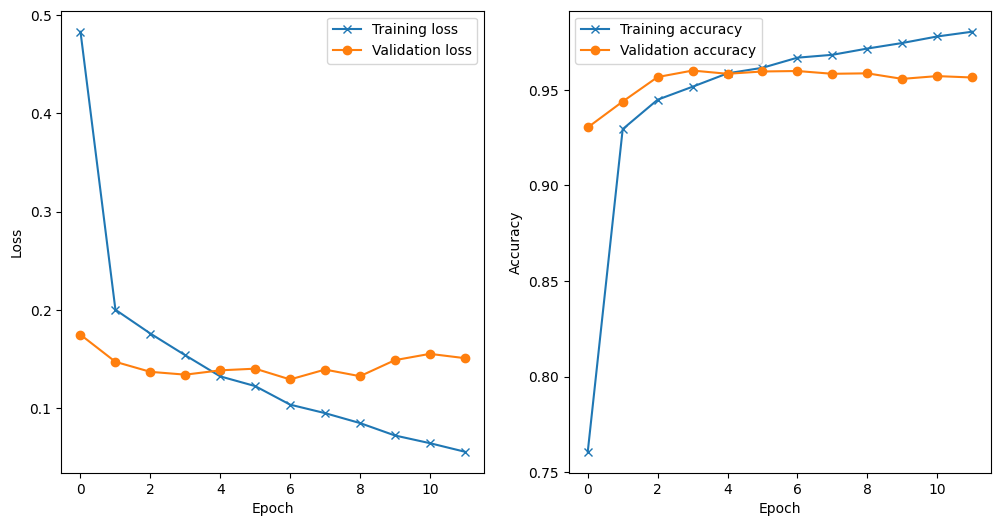

In [22]:
# Plotting loss
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(train.history['loss'], 'x-', label="Training loss")
plt.plot(train.history['val_loss'], 'o-', label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train.history['accuracy'], 'x-', label="Training accuracy")
plt.plot(train.history['val_accuracy'], 'o-', label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

As we can see, the validation accuracy is already very high in the first epoch. It improves slightly for a few epochs, then plateaus. The same goes for the validation loss. 
On the other hand, the training accuracy and loss improve consistently. We have some overfitting, but in the end the test accuracy is significantly better than for the traditional approach taken in Q1.